In [1]:
from IPython.display import Image
import os
from scipy import misc
from scipy import ndimage
from scipy.misc import toimage
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')


from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Reshape
import glob

from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob
import math

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
ridge = Ridge(alpha=2) # need to justify this value :::: RIDGE REGRESSION

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]


def load_images_by_filename(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    #return images
    return houses

def rmse(predictions,targets):
    return np.sqrt(((predictions - targets)**2).mean())

def percentwithin10(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets[i]) < 0.10 * targets[i]:
            count+=1;
    return count / len(targets);

def percentwithin10_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.10 * targets[i]:
            count+=1
    print ('total count ' + str(count)+ ' out of ' + str(len(targets)))
    return count / len(targets);

def percentwithin20(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions.iloc[i] - targets.iloc[i]) < 0.20 * targets.iloc[i]:
            count+=1;
    return count / len(targets);

def percentwithin20_1(predictions,targets):
    count = 0;
    for i in range(0,len(targets)):
        if math.fabs(predictions[i] - targets[i]) < 0.20 * targets[i]:
            count+=1;
    return count / len(targets);

#Euclidean Distance function
#compare a row's distance columns to a particular preset target's columns
distance_columns = ['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE','LATITUDE','LONGITUDE']
def eu_dist(row, target):
    value = 0
    for k in distance_columns:
        value += (row[k] - target[k]) ** 2
    return math.sqrt(value)

def parse_filename(long_name):
    part = long_name.split('.')
    part = part[1].split('_')
    return part[0]

def load_images_to_map(pic_list):
    houses = dict()
    for filename in pic_list:
        img = misc.imread(filename)
        if img is not None:
            houses[parse_filename(filename)]=np.array(img)
            #images.append(np.array(img))
    return houses

def predict_features(image_data, model):
    predicted = model.predict(image_data.reshape(1,128,192,3))
    return predicted

def convertPrice(adjP, local_median, df4):
    global_median = np.median(df4.MEDIAN)
    price = adjP / (global_median / local_median)
    return price

def get_median_error(pred, truth):
    vals = []
    for i in range(0,len(pred)):
        err = math.fabs(pred[i] - truth[i])
        percent = err / truth[i]
        vals.append(percent)
    return np.median(vals)
    
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold 

Using TensorFlow backend.
D:\Anaconda3_10\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Anaconda3_10\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_dataframe():
    #load the dataframe

    # read in data about houses...clean data, normalize, and bring in zip code medians
    path = "D:/thesis/*.csv"
    allFiles = glob.glob(path)
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)

    frame.columns = ['SALE', 'DATE', 'PROP_TYPE', 'ADDRESS', 'CITY', 'STATE',
           'ZIP', 'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'DAYS_ON_MARKET', 'DL_SQFT', 'HOA', 'STATUS',
           'TIME1', 'TIME2',
           'URL',
           'SOURCE', 'MLS', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE']

    df2 = frame[['DATE','DAYS_ON_MARKET','DL_SQFT','MLS','ZIP','CITY','PRICE','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE']]


    df2 = df2[np.isfinite(df2['PRICE'])]
    df2['BATHS'] = df2['BATHS'].fillna(df2['BATHS'].median())
    df2['BEDS'] = df2['BEDS'].fillna(df2['BEDS'].median())

    df2['DAYS_ON_MARKET'] = df2['DAYS_ON_MARKET'].fillna(df2['DAYS_ON_MARKET'].median())
    df2['SQ_FEET'] = df2['SQ_FEET'].fillna(df2['SQ_FEET'].mean())
    df2['LOT_SIZE'] = df2['LOT_SIZE'].fillna(df2['LOT_SIZE'].mean())
    df2['HOA'] = df2['HOA'].fillna(0)
    df2['YEAR_BUILT'] = df2['YEAR_BUILT'].fillna(df2['YEAR_BUILT'].median())

    df2 = df2.drop_duplicates() 
    df2.count()

    logAge = np.log(2019 - df2.YEAR_BUILT)
    df2['logAge'] = logAge

    df2.loc[df2.ZIP == 46001,'ZIP'] = 46168
    df2.loc[df2.ZIP == 46067,'ZIP'] = 46077
    df2.loc[df2.CITY == 'Noblesville','ZIP'] = 46062

    df_medians = pd.read_csv("D:/thesis/medians/Book3.csv", index_col = None, header = None, names = ['ZIP','b','c','d', 'MEDIAN'])
    del df_medians['b']
    del df_medians['c']
    del df_medians['d']

    df4 = pd.merge(df2, df_medians, on='ZIP', how='left')

    df4 = df4.dropna()
    df4.MLS = df4.MLS.astype('int32')
    df4.MLS = df4.MLS.astype(str)

    # MUST DO THIS POST SPLIT!!!!!!!!!!!!!!!!!!!!!!
    #######################################################################
    #df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
    #       'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.fit_transform(df4[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
     #      'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    #######################################################################3
    #remove price outliers
    #df4 = df4[df4.PRICE <= 800000]

    # fix this single zip error ~!!!!!!!!!!!!!!CHECK THIS 
    #df4.MEDIAN[df4.ZIP == 46203] = 60200  
    
    return df4

def split_prepare_data(df):
    
    X_train, X_test = train_test_split(df, test_size = 0.2)
    
    X_train[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.fit_transform(X_train[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    X_test[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']] =  min_max_scaler.transform(X_test[['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN', 'DAYS_ON_MARKET']])
    
    return X_train, X_test

def normalize_NN(X_train, X_test):
    X_train[['NN1', 'NN2', 'NN3', 'NN4','NN5']] =  min_max_scaler.fit_transform(X_train[['NN1', 'NN2', 'NN3', 'NN4','NN5']])
    X_test[['NN1', 'NN2', 'NN3', 'NN4','NN5']] =  min_max_scaler.transform(X_test[['NN1', 'NN2', 'NN3', 'NN4','NN5']])
    return X_train, X_test

def load_image_map():
    picfiles = glob.glob('d:/house_images_2/**/*.jpg', recursive=True)
    h = load_images_to_map(picfiles)
    return h

# takes target dataframe and training dataframe as parameters
#target = X_train.iloc[1]
def run_NN(df, X_train):
    # nearest neighbors columns on training data
    # long calculation time > 2 hours
    #distance_columns = ['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE','LATITUDE','LONGITUDE']
    df5 = X_train[['SQ_FEET', 'LATITUDE','LONGITUDE','logAge','LOT_SIZE']]
    nn1 = []
    nn2 = []
    nn3 = []
    nn4 = []
    nn5 = []
    for i in range(df.shape[0]):
    #for i in range(5):
        target = df.iloc[i]
        #print(target)
        distances = df5.apply(eu_dist, target = target, axis = 1)
        #print(distances)
        distances_frame = pd.DataFrame(data = {"dist":distances, 'idx':distances.index})
        distances_frame.sort_values(by = ['dist'], inplace=True)
        distances_frame_short = distances_frame.iloc[0:6]
        #print(distances_frame_short)
        nn1.append( X_train.PRICE[distances_frame_short.idx.iloc[1]])
        nn2.append( X_train.PRICE[distances_frame_short.idx.iloc[2]])
        nn3.append( X_train.PRICE[distances_frame_short.idx.iloc[3]])
        nn4.append( X_train.PRICE[distances_frame_short.idx.iloc[4]])
        nn5.append( X_train.PRICE[distances_frame_short.idx.iloc[5]])
        if ( i % 500) == 0:
            print(str(i/df.shape[0]) + ' of ' + str(df.shape[0]))
    #add the new features to the data used in the regression

    df['NN1']= nn1
    df['NN2']= nn2
    df['NN3']= nn3
    df['NN4']= nn4
    df['NN5']= nn5
    
    #print(nn1)
    
    return df

def set_adjusted(X_train_set, X_test_set):
    # ADD ADJUSTED PRICING TO DATAFRAMES
    #median of medians in each zip

    medPrice = np.median(X_train_set.MEDIAN)
    #fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0

    #price adjusted by location / ZIP FOR TRAINING SET

    X_train_set['adjPRICE'] = X_train_set['PRICE'] * (medPrice / X_train_set['MEDIAN'])

    #NEW Populate medians in test data

    #price adjusted by location / ZIP from TRAINING
    #populate the testing set with adjusted prices

    X_test_set['adjPRICE'] = X_test_set['PRICE'] * (medPrice / X_test_set['MEDIAN']) 
    
    return X_train_set, X_test_set

def set_adjusted_2(X_train_set, X_test_set):

    #medPrice = np.median(X_train_set.MEDIAN)
    #fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0

    #price adjusted by location / ZIP FOR TRAINING SET

    X_train_set['adjPRICE_NN'] = (X_train_set['NN1'] + X_train_set['NN2'] + X_train_set['NN3'] +
                                  X_train_set['NN4'] + X_train_set['NN5'])/5.0

    #NEW Populate medians in test data

    #price adjusted by location / ZIP from TRAINING
    #populate the testing set with adjusted prices

    X_test_set['adjPRICE_NN'] = (X_test_set['NN1'] + X_test_set['NN2'] + X_test_set['NN3'] +
                                  X_test_set['NN4'] + X_test_set['NN5'])/5.0
    
    return X_train_set, X_test_set

def create_image_split_2(df, h):   # takes dataframe and image map
    # 
    #   create lists for pics, MLS, and price
    #   order is maintained
    pics = []
    nums = []
    prices = []
    df4 = df
    for key in list(h):
        val = df4.where(df4.MLS == key).dropna() 
        if val.size != 0 and math.isinf(val.resids.item()) == False:
            resized = misc.imresize(h[key], (200, 300)).astype('float32')
            prices.append(val.resids.astype('float32').item())
            pics.append(resized)
            nums.append(key)

    # save them as numpy arrays

    nums = np.array(nums)
    pics = np.array(pics)
    prices = np.array(prices)
    
    return nums, pics, prices

def build_cnn():
    # build the CNN

    datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2, #0.1
        height_shift_range=0.2, #0.1
        #shear_range=0.1,
        horizontal_flip=True,
        channel_shift_range = 0.2, #tried 0.1
        fill_mode='nearest',
        #zca_whitening = False,
        #featurewise_std_normalization = True,
        data_format='channels_last')

    #datagen.fit(train_X,augment = True, verbose = 1)
    
    lrate = 0.001
    rms = RMSprop(lr=lrate)
    model = Sequential()

    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape = (128,192,3),
                     data_format='channels_last', kernel_constraint=maxnorm(3)))
                     #kernel_regularizer=regularizers.l1(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', data_format='channels_last',
                    kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', data_format='channels_last',
                    kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2), data_format='channels_last'))

    model.add(Flatten())
    model.add(Dense(3072, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.20))
    model.add(Dense(1))
  

    model.compile(loss='mean_absolute_error', optimizer=rms) 
    return model, datagen

def run_cnn_training(model, epochs, batch_size, steps):
    history = model.fit_generator(datagen.flow(x=train_X, y=train_ground, batch_size=batch_size), epochs=epochs,
                    steps_per_epoch = steps, verbose=1,
                    validation_data=(valid_X, valid_ground))
    return history

def create_merged_frames():
    ######################

    # find predictions, add to dataframe

    train_map = dict()
    for i in range(len(prices)):
        train_map[nums[i]] = model.predict(pics[i].reshape(1,128,192,3)).flatten().item()

    df_images = pd.DataFrame.from_dict(train_map, orient='index', columns = ['predPrice'])

    merged = X_train.merge(df_images, left_on = 'MLS', right_index = True, how = 'left' )

    train_map2 = dict()
    for i in range(len(prices2)):
        train_map2[nums2[i]] = model.predict(pics2[i].reshape(1,128,192,3)).flatten().item()

    df_images2 = pd.DataFrame.from_dict(train_map2, orient='index', columns = ['predPrice'])

    merged2 = X_test.merge(df_images2, left_on = 'MLS', right_index = True, how = 'left' )

    merged['convert_pred'] = convertPrice(merged['predPrice'], merged['MEDIAN'], X_train)

    merged2['convert_pred'] = convertPrice(merged2['predPrice'], merged2['MEDIAN'], X_train)
    
    fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0
    merged.convert_pred = merged.convert_pred.fillna(fill_value)
    fill_value2 = (merged2['NN1'] + merged2['NN2'] + merged2['NN3'] + merged2['NN4'] + merged2['NN5'])/5.0
    merged2.convert_pred = merged2.convert_pred.fillna(fill_value2)
    return merged, merged2


def create_merged_frames_3():
    ######################

    # find predictions, add to dataframe

    train_map = dict()
    for i in range(len(prices)):
        train_map[nums[i]] = model.predict(pics[i].reshape(1,128,192,3)).flatten().item()

    df_images = pd.DataFrame.from_dict(train_map, orient='index', columns = ['predPrice'])

    merged = X_train.merge(df_images, left_on = 'MLS', right_index = True, how = 'left' )

    train_map2 = dict()
    for i in range(len(prices2)):
        train_map2[nums2[i]] = model.predict(pics2[i].reshape(1,128,192,3)).flatten().item()

    df_images2 = pd.DataFrame.from_dict(train_map2, orient='index', columns = ['predPrice'])

    merged2 = X_test.merge(df_images2, left_on = 'MLS', right_index = True, how = 'left' )

    merged['convert_pred'] = convertPrice(merged['predPrice'], merged['MEDIAN'], X_train)

    merged2['convert_pred'] = convertPrice(merged2['predPrice'], merged2['MEDIAN'], X_train)
    
    fill_value = (merged['NN1'] + merged['NN2'] + merged['NN3'] + merged['NN4'] + merged['NN5'])/5.0
    merged.convert_pred = merged.convert_pred.fillna(fill_value)
    fill_value2 = (merged2['NN1'] + merged2['NN2'] + merged2['NN3'] + merged2['NN4'] + merged2['NN5'])/5.0
    merged2.convert_pred = merged2.convert_pred.fillna(fill_value2)
    return merged, merged2

In [3]:
def create_image_split(df, h):   # takes dataframe and image map
    # 
    #   create lists for pics, MLS, and price
    #   order is maintained
    pics = []
    nums = []
    prices = []
    df4 = df
    for key in list(h):
        val = df4.where(df4.MLS == key).dropna() 
        if val.size != 0 and math.isinf(val.PRICE.item()) == False:
            resized = misc.imresize(h[key], (128, 192)).astype('float32')
            prices.append(val.PRICE.astype('float32').item())
            pics.append(resized)
            nums.append(key)

    # save them as numpy arrays

    nums = np.array(nums)
    pics = np.array(pics)
    prices = np.array(prices)
    
    return nums, pics, prices

In [4]:
house_data = load_dataframe()
features= ['MLS','PRICE','BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']
house_data = house_data.dropna()
X = house_data[features]
y = house_data.PRICE

In [5]:
image_map = load_image_map()

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:111: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [6]:
nums, pics, prices = create_image_split(X, image_map)

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [7]:
pics2 = pics/255

In [12]:
pics2

array([[[[0.7294118 , 0.7764706 , 0.8627451 ],
         [0.6039216 , 0.67058825, 0.7764706 ],
         [0.5372549 , 0.6156863 , 0.74509805],
         ...,
         [0.73333335, 0.77254903, 0.8627451 ],
         [0.7176471 , 0.75686276, 0.8627451 ],
         [0.75686276, 0.7921569 , 0.8784314 ]],

        [[0.74509805, 0.8039216 , 0.8784314 ],
         [0.6117647 , 0.6901961 , 0.7921569 ],
         [0.5372549 , 0.61960787, 0.75686276],
         ...,
         [0.7019608 , 0.7490196 , 0.8509804 ],
         [0.6901961 , 0.7372549 , 0.85882354],
         [0.72156864, 0.76862746, 0.8627451 ]],

        [[0.70980394, 0.7882353 , 0.87058824],
         [0.6117647 , 0.69803923, 0.8156863 ],
         [0.5411765 , 0.627451  , 0.78039217],
         ...,
         [0.6745098 , 0.73333335, 0.85490197],
         [0.65882355, 0.7176471 , 0.85882354],
         [0.6784314 , 0.7372549 , 0.84705883]],

        ...,

        [[0.35686275, 0.29803923, 0.2509804 ],
         [0.34117648, 0.27450982, 0.21568628]

In [ ]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50


In [8]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(pics2,
                                                             pics2, 
                                                             test_size=split, 
                                                             random_state=13)
print(train_X.shape, valid_X.shape)

(4379, 128, 192, 3) (1095, 128, 192, 3)


In [ ]:
# HERE WE GO WITH THE AUTOENCODER  

In [17]:
# new attempt with flat middle layer

input_img = Input(shape=(128,192,3))
#model = Sequential()
x = Conv2D(32, (3, 3), padding='same', activation='relu',
                 data_format='channels_last',kernel_constraint=maxnorm(3))(input_img)
x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last', name='firstL',)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
encoded = MaxPooling2D(pool_size=(2, 2), data_format='channels_last', name='encoder')(x)
#encoded = Flatten() (x)# new, flatten the weights
#encoded = Dense(4096, name='encoder')(x)
#model.add(MaxPooling2D(pool_size=(2, 2)))
#now encoded
#x = Dense(12288)(encoded)
#x = Reshape(target_shape = (16,24,32))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same', data_format='channels_last')(encoded)
x = UpSampling2D((2, 2),data_format='channels_last')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2),data_format='channels_last')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2),data_format='channels_last')(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
#x = UpSampling2D((2, 2), data_format='channels_last')(x)
#decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', data_format='channels_last')(x)
#model.add(UpSampling2D((2, 2)))
#complete decode
#model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
autoencoder = Model(input_img,decoded)         

# Compile model
epochs = 300  #set low to keep time down
#lrate = 0.01
#decay = lrate/epochs
#sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
rms = RMSprop()
autoencoder.compile(loss='mean_squared_error', optimizer=rms, metrics=['mae'])

print(autoencoder.summary())
model_trained = autoencoder.fit(train_X, train_ground, batch_size=32,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))
autoencoder.save('autoencoder.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 192, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 192, 32)      896       
_________________________________________________________________
firstL (MaxPooling2D)        (None, 64, 96, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 48, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 48, 32)        9248      
_________________________________________________________________
encoder (MaxPooling2D)       (None, 16, 24, 32)        0         
__________

4379/4379 [==============================] - 9s - loss: 0.0058 - mean_absolute_error: 0.0567 - val_loss: 0.0057 - val_mean_absolute_error: 0.0570
Epoch 39/300
4379/4379 [==============================] - 9s - loss: 0.0058 - mean_absolute_error: 0.0568 - val_loss: 0.0067 - val_mean_absolute_error: 0.0619
Epoch 40/300
4379/4379 [==============================] - 9s - loss: 0.0058 - mean_absolute_error: 0.0566 - val_loss: 0.0056 - val_mean_absolute_error: 0.0561
Epoch 41/300
4379/4379 [==============================] - 9s - loss: 0.0057 - mean_absolute_error: 0.0565 - val_loss: 0.0058 - val_mean_absolute_error: 0.0576
Epoch 42/300
4379/4379 [==============================] - 9s - loss: 0.0057 - mean_absolute_error: 0.0561 - val_loss: 0.0055 - val_mean_absolute_error: 0.0550
Epoch 43/300
4379/4379 [==============================] - 9s - loss: 0.0056 - mean_absolute_error: 0.0558 - val_loss: 0.0062 - val_mean_absolute_error: 0.0609
Epoch 44/300
4379/4379 [==============================] - 9

4379/4379 [==============================] - 9s - loss: 0.0046 - mean_absolute_error: 0.0500 - val_loss: 0.0040 - val_mean_absolute_error: 0.0453
Epoch 90/300
4379/4379 [==============================] - 9s - loss: 0.0046 - mean_absolute_error: 0.0497 - val_loss: 0.0059 - val_mean_absolute_error: 0.0577
Epoch 91/300
4379/4379 [==============================] - 9s - loss: 0.0046 - mean_absolute_error: 0.0495 - val_loss: 0.0049 - val_mean_absolute_error: 0.0524
Epoch 92/300
4379/4379 [==============================] - 9s - loss: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0039 - val_mean_absolute_error: 0.0437
Epoch 93/300
4379/4379 [==============================] - 9s - loss: 0.0045 - mean_absolute_error: 0.0494 - val_loss: 0.0051 - val_mean_absolute_error: 0.0537
Epoch 94/300
4379/4379 [==============================] - 9s - loss: 0.0046 - mean_absolute_error: 0.0494 - val_loss: 0.0039 - val_mean_absolute_error: 0.0446
Epoch 95/300
4379/4379 [==============================] - 9

4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0473 - val_loss: 0.0041 - val_mean_absolute_error: 0.0470
Epoch 141/300
4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0474 - val_loss: 0.0040 - val_mean_absolute_error: 0.0459
Epoch 142/300
4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0474 - val_loss: 0.0044 - val_mean_absolute_error: 0.0487
Epoch 143/300
4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0043 - val_mean_absolute_error: 0.0480
Epoch 144/300
4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0471 - val_loss: 0.0038 - val_mean_absolute_error: 0.0437
Epoch 145/300
4379/4379 [==============================] - 9s - loss: 0.0042 - mean_absolute_error: 0.0471 - val_loss: 0.0042 - val_mean_absolute_error: 0.0472
Epoch 146/300
4379/4379 [=============================

4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0458 - val_loss: 0.0043 - val_mean_absolute_error: 0.0492
Epoch 192/300
4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0460 - val_loss: 0.0040 - val_mean_absolute_error: 0.0461
Epoch 193/300
4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0459 - val_loss: 0.0040 - val_mean_absolute_error: 0.0463
Epoch 194/300
4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0459 - val_loss: 0.0039 - val_mean_absolute_error: 0.0451
Epoch 195/300
4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0460 - val_loss: 0.0043 - val_mean_absolute_error: 0.0477
Epoch 196/300
4379/4379 [==============================] - 9s - loss: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0047 - val_mean_absolute_error: 0.0520
Epoch 197/300
4379/4379 [=============================

4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0451 - val_loss: 0.0039 - val_mean_absolute_error: 0.0456
Epoch 243/300
4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0448 - val_loss: 0.0038 - val_mean_absolute_error: 0.0453
Epoch 244/300
4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0452 - val_loss: 0.0039 - val_mean_absolute_error: 0.0447
Epoch 245/300
4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0451 - val_loss: 0.0037 - val_mean_absolute_error: 0.0434
Epoch 246/300
4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0451 - val_loss: 0.0037 - val_mean_absolute_error: 0.0433
Epoch 247/300
4379/4379 [==============================] - 9s - loss: 0.0039 - mean_absolute_error: 0.0449 - val_loss: 0.0042 - val_mean_absolute_error: 0.0464
Epoch 248/300
4379/4379 [=============================

4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0448 - val_loss: 0.0037 - val_mean_absolute_error: 0.0438
Epoch 294/300
4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0038 - val_mean_absolute_error: 0.0450
Epoch 295/300
4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0038 - val_mean_absolute_error: 0.0445
Epoch 296/300
4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0041 - val_mean_absolute_error: 0.0464
Epoch 297/300
4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0034 - val_mean_absolute_error: 0.0408
Epoch 298/300
4379/4379 [==============================] - 9s - loss: 0.0038 - mean_absolute_error: 0.0446 - val_loss: 0.0031 - val_mean_absolute_error: 0.0382
Epoch 299/300
4379/4379 [=============================

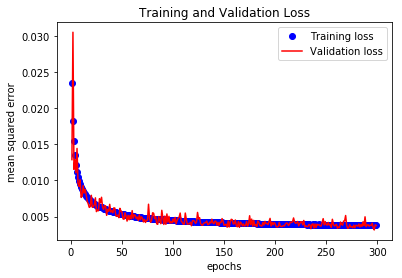

In [67]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.legend()
plt.show()

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


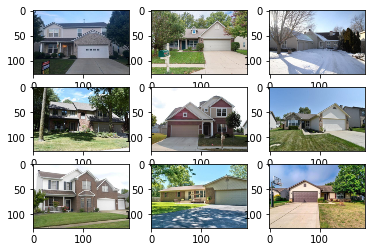

D:\Anaconda3_10\lib\site-packages\ipykernel\__main__.py:15: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


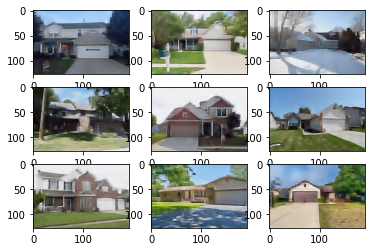

In [19]:
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
pred = autoencoder.predict(valid_X)

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(valid_X[i]))
    #plt.imshow(Image.fromarray(valid_X[i]))
    #Image.fromarray
# show the plot
plt.show()

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(toimage(pred[i]))
# show the plot
plt.show()

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
kf = KFold(n_splits= 10, shuffle = True)
scaler = MinMaxScaler()

In [20]:
autoencoder = load_model('autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

In [23]:
len(features)

5474

In [24]:
#populate features into map

img_pred_map = { }
#pro_pics = preprocess_input(pics)
features = encoder.predict(pics2)
features = np.reshape(features,(5474,12288))
for i in range(len(pics2)):
    img_pred_map[nums[i]] = features[i]

In [25]:
image_frame = pd.DataFrame.from_dict(img_pred_map, orient = 'index')

In [27]:
image_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
21524287,0.012175,0.060759,0.056870,0.025516,0.099897,0.003216,0.194426,0.022157,0.046910,0.029568,...,0.0,0.015919,0.000000,0.023903,0.026965,0.041012,0.073802,0.000000,0.013402,0.070271
21480102,0.010255,0.033968,0.089451,0.066984,0.090038,0.003303,0.010943,0.022422,0.033742,0.042670,...,0.0,0.004204,0.027708,0.034743,0.016314,0.036214,0.010262,0.024518,0.023291,0.056792
21495651,0.017274,0.030283,0.031653,0.034588,0.308097,0.038690,0.189696,0.013323,0.030898,0.015271,...,0.0,0.000000,0.000000,0.040105,0.026894,0.033439,0.097806,0.000000,0.010240,0.070652
21505438,0.065817,0.072794,0.081202,0.057540,0.178496,0.094073,0.080808,0.048650,0.100102,0.066079,...,0.0,0.007455,0.000000,0.015849,0.115706,0.038392,0.114123,0.006764,0.000000,0.115642
21527131,0.022629,0.051734,0.021629,0.060750,0.000000,0.027726,0.000000,0.005180,0.041232,0.000000,...,0.0,0.004459,0.000000,0.050517,0.023737,0.020598,0.188337,0.000000,0.015472,0.097530


In [26]:
pre_scaled = pd.DataFrame(scaler.fit_transform(image_frame), index=image_frame.index)

NameError: name 'scaler' is not defined

In [30]:
#image_frame = pre_scaled
n_components=100
pca = PCA(n_components)
pca_result = pca.fit_transform(image_frame.values)

print ('Cumulative explained variation for principal components: {}'
           .format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for principal components: 0.7994261674672335


In [31]:
n_components = 100
pca = PCA(n_components)
#pca_result_50 = pca_50.fit_transform(merged.values)
pca_frame = pd.DataFrame(pca.fit_transform(image_frame.values), columns=['PCA%i' % i for i in range(n_components)], index=image_frame.index)

In [50]:
#merge features to standard data PCA VERSION

merged = X.merge(pca_frame, left_on = 'MLS', right_index = True, how = 'inner' )

In [ ]:
#merge features to standard data ALL DATA

merged = X.merge(pre_scaled, left_on = 'MLS', right_index = True, how = 'inner' )

In [46]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(X,
                                                             y, 
                                                             test_size=split 
                                                             )
print(train_X.shape, valid_X.shape)

(4740, 13) (1186, 13)


In [41]:
features= ['BEDS', 'BATHS', 'SQ_FEET', 'LOT_SIZE','DAYS_ON_MARKET',
           'YEAR_BUILT', 'HOA', 'LATITUDE', 'LONGITUDE', 'logAge', 'MEDIAN']

In [43]:
transformer = min_max_scaler.fit(train_X[features])

In [49]:
train_X.head()

,MLS,PRICE,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS_ON_MARKET,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,MEDIAN
3629,21540038,97000.0,2.0,1.5,1136.0,5880.0,29.0,1989.0,0.0,39.634509,-86.098785,3.401197,172145.0
3743,21495670,215900.0,4.0,2.5,2539.0,9452.0,141.0,2003.0,16.0,39.596815,-86.079342,2.772589,172145.0
4376,21527530,89000.0,3.0,1.5,2548.0,23522.0,65.0,1900.0,0.0,39.650899,-86.191590,4.779123,147579.0
1717,21510274,239900.0,4.0,2.5,2986.0,14810.0,154.0,1993.0,30.0,40.048205,-86.086190,3.258097,220839.0
1828,21522013,497500.0,5.0,5.0,5328.0,18730.0,13.0,2005.0,80.0,40.006593,-86.051347,2.639057,220839.0


In [47]:
#merge features to standard data PCA VERSION

merged = train_X.merge(pca_frame, left_on = 'MLS', right_index = True, how = 'inner' )

In [51]:
df2 = merged.loc[:, merged.columns != 'MLS']
y = merged.PRICE
df2 = df2.loc[:, df2.columns != 'PRICE']

In [54]:
df2.head()


,BEDS,BATHS,SQ_FEET,LOT_SIZE,DAYS_ON_MARKET,YEAR_BUILT,HOA,LATITUDE,LONGITUDE,logAge,...,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99
1,4.0,2.5,3923.0,16117.0,139.0,1990.0,29.0,39.972871,-86.165201,3.367296,...,0.260471,0.018401,-0.373606,0.122414,-0.165061,-0.110373,0.033150,-0.536421,0.352631,-0.327858
2,5.0,4.5,6768.0,15681.0,139.0,2016.0,75.0,39.965305,-86.176621,1.098612,...,0.690698,0.677355,0.550017,0.690018,0.506677,0.144068,-0.352969,0.142370,0.113372,-0.447209
3,4.0,4.0,5124.0,18295.0,127.0,1996.0,50.0,39.936647,-86.228057,3.135494,...,0.118427,0.272300,-0.421020,0.237087,-0.519533,-0.173665,-0.203163,-0.335685,-0.238086,0.103030
4,5.0,5.0,7732.0,26136.0,125.0,2000.0,50.0,39.938926,-86.219860,2.944439,...,-0.190871,-0.017298,0.556157,-0.416095,-0.347382,0.430823,0.566956,0.231381,-0.154529,-0.319754
5,3.0,3.5,5462.0,69696.0,135.0,1983.0,19.0,39.932524,-86.171818,3.583519,...,0.002733,0.210821,0.221382,-0.555184,-0.640919,-0.178797,-0.134341,-1.113637,0.005739,-0.311674


In [56]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(df2,
                                                             y, 
                                                             test_size=split 
                                                             )
print(train_X.shape, valid_X.shape)
transformer = min_max_scaler.fit(train_X)
train_X = pd.DataFrame(transformer.transform(train_X), index = train_X.index, columns = train_X.columns)
valid_X = pd.DataFrame(transformer.transform(valid_X), index = valid_X.index, columns = valid_X.columns)

(4379, 111) (1095, 111)


In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV

In [59]:
gb_grid_params = {'learning_rate': [0.01, 0.1],
              'max_depth': [ 4, 8],
              'min_samples_leaf': [10, 20, 50],
              'max_features': [0.1, 0.3, 0.5],
              'n_estimators' : [500,700,1000] 
              }

rf = GradientBoostingRegressor(loss = 'ls')
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = gb_grid_params, 
                               n_iter = 96, cv = 3, 
                               verbose=2, n_jobs = -1)

In [60]:
rf_random.fit(df2, y)
print(rf_random.best_params_)
best = rf_random.best_estimator_

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 13.8min finished


{'min_samples_leaf': 10, 'max_depth': 4, 'max_features': 0.3, 'learning_rate': 0.01, 'n_estimators': 1000}


In [65]:
#cross validation of models
X = df2

sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X):
    
    #get splits of pandas dataframes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_train.values
    X_tested = X_test.values
    y_trained = y_train.values
    y_tested = y_test.values
    
    #rf = GradientBoostingRegressor(loss = 'ls', n_estimators = 700  )
    #rf.fit (X_train,y_train )
    
    #rf = RandomForestRegressor(n_estimators = 100)
    #rf.fit(X_train[features],X_train.PRICE )
    
    #rf = Ridge(alpha=2)
    #rf.fit(X_train, y_train ) 
    
    #rf = linear_model.LinearRegression()
    #rf.fit (X_train,y_train )
    
    #rf = build_model()
    #rf.fit(X_trained, y_trained, epochs=1000, verbose = 1)
    
    rf = best
    rf.fit( X_train, y_train )
    
  
    preds = rf.predict(X_test)
    y_test = y.values

    
    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("accuracy validation: " + str(perc10))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
print("average mer: " + str(sum_mer/10))
    

total count 292 out of 548
accuracy validation: 0.5328467153284672
median error: 0.09525088281084773
------------------
total count 298 out of 548
accuracy validation: 0.5437956204379562
median error: 0.09025695322248137
------------------
total count 293 out of 548
accuracy validation: 0.5346715328467153
median error: 0.09120672088328932
------------------
total count 298 out of 548
accuracy validation: 0.5437956204379562
median error: 0.08988329611420742
------------------
total count 307 out of 547
accuracy validation: 0.5612431444241316
median error: 0.08740551038498974
------------------
total count 291 out of 547
accuracy validation: 0.5319926873857403
median error: 0.09540774304159957
------------------
total count 289 out of 547
accuracy validation: 0.5283363802559415
median error: 0.09529293754174238
------------------
total count 305 out of 547
accuracy validation: 0.5575868372943327
median error: 0.0865799122168596
------------------
total count 312 out of 547
accuracy valid

In [62]:
n_estimators = [2000,4000,6000]
#n_estimators = [4000]
max_features = ['auto']
max_depth = [75,110,130]
max_depth.append(None)
min_samples_split = [ 5, 10, 15]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [63]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = 3, 
                               verbose=2, n_jobs = 5)

In [64]:
rf_random.fit(df2, y)
print(rf_random.best_params_)
best = rf_random.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 177.1min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed: 368.4min finished


{'min_samples_leaf': 2, 'max_depth': None, 'n_estimators': 2000, 'min_samples_split': 5, 'bootstrap': True, 'max_features': 'auto'}


In [ ]:
shape = np.shape(pre_scaled)
print(shape)

In [ ]:
df2.head()

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
from keras.layers.normalization import BatchNormalization

In [ ]:
from keras.layers import Merge

In [ ]:
split=0.2

train_X,valid_X,train_ground,valid_ground = train_test_split(df2,
                                                             y, 
                                                             test_size=split, 
                                                             random_state=13)
print(train_X.shape, valid_X.shape)

In [ ]:
train_X.head()

In [ ]:
data_features = ['DAYS_ON_MARKET','BEDS','BATHS','SQ_FEET','LOT_SIZE','YEAR_BUILT',
                'HOA','LATITUDE','LONGITUDE','logAge','MEDIAN']

In [ ]:
df2[data_features].head()

In [ ]:
cols = [col for col in df2.columns if col not in data_features]

In [ ]:
train_X[cols].head()

In [ ]:
#set input shape to autoencoder inner later shape, then fully connect those layers



In [ ]:

def build_model():
    branch1 = Sequential()
    branch1.add(Dense(512, activation = 'relu', input_shape=(12288,)))
    branch1.add(Dropout(0.2))
    #branch1.add(Dense(256,activation = 'relu'))
    #branch1.add(BatchNormalization())
    branch1.add(Dense(128,activation = 'relu'))
    branch1.add(Dropout(0.2))
    branch1.add(Dense(128,activation = 'relu'))
    branch1.add(Dropout(0.2))
    print(branch1.summary())
    
    branch2 = Sequential()
    branch2.add(Dense(64, activation = 'relu', input_shape=(11,)))
    #branch2.add(BatchNormalization())
    branch2.add(Dense(64, activation = 'relu'))
    #branch2.add(BatchNormalization())
    print(branch2.summary())
    
    model = Sequential()
    model.add(Merge([branch1,branch2], mode = 'concat'))
    #model.add(Dense(320, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(1))

    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
    return model

In [ ]:
epochs = 300
X1 = train_X[data_features].as_matrix()
X2 = train_X[cols].as_matrix()
valid_X1 = valid_X[data_features].as_matrix()
valid_X2 = valid_X[cols].as_matrix()
rf = build_model()
print(rf.summary())
model_trained = rf.fit([X2,X1], train_ground, epochs=epochs, verbose = 1,
                       validation_data=([valid_X2,valid_X1], valid_ground))

In [ ]:
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epoch = range(epochs)
plt.figure()
plt.plot(epoch[1:], loss[1:], 'bo', label='Training loss')
#plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch[1:], val_loss[1:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [ ]:
preds = rf.predict([valid_X2,valid_X1])
mer = get_median_error(preds, valid_ground.values)
acc = percentwithin10_1(valid_ground.values, preds)
print("acc: " + str(acc))
print("mer: " + str(mer))


In [ ]:
preds = rf.predict([X2,X1])
mer = get_median_error(preds, train_ground.values)
acc = percentwithin10_1(train_ground.values, preds)
print("acc: " + str(acc))
print("mer: " + str(mer))

In [ ]:
cross validation of models
X = df2

sum_acc = 0
sum_r2 = 0
sum_mae = 0
sum_mer = 0
for train_index, test_index in kf.split(X):
    
    #get splits of pandas dataframes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    #change to numpy arrays - watch the -ed for non NN
    X_trained = X_train.values
    X_tested = X_test.values
    y_trained = y_train.values
    y_tested = y_test.values
    
    #rf = GradientBoostingRegressor(loss = 'ls', n_estimators = 700  )
    #rf.fit (X_train,y_train )
    
    #rf = RandomForestRegressor(n_estimators = 100)
    #rf.fit(X_train[features],X_train.PRICE )
    
    #rf = Ridge(alpha=2)
    #rf.fit(X_train, y_train ) 
    
    #rf = linear_model.LinearRegression()
    #rf.fit (X_train,y_train )
    
    rf = build_model()
    rf.fit(X_trained, y_trained, epochs=1000, verbose = 1)
    
    #rf = best
    #rf.fit( X_train, y_train )
    
  
    preds = rf.predict(X_test)
    y_test = y.values

    
    mer = get_median_error(preds, y_tested)
    r2 = r2_score(y_tested, preds)
    mae = mean_absolute_error(y_tested, preds)
    perc10 = percentwithin10_1(y_tested, preds)
    
    print("accuracy validation: " + str(perc10))
    print("median error: " + str(mer))
    
    sum_acc += perc10
    sum_r2 += r2
    sum_mae += mae
    sum_mer += mer
    
    print('------------------')

print("average acc: " + str(sum_acc/10))
print("average mer: " + str(sum_mer/10))
    